In [1]:
import warnings
import numpy as np
import pandas as pd
import os
from pathlib import Path
import subprocess

warnings.filterwarnings("ignore")

In [2]:
import torch
import torchaudio
from torch.nn.functional import pad
import torchaudio.functional as F
import torchaudio.transforms as T
from tqdm import tqdm
from transformers import Wav2Vec2Tokenizer, Wav2Vec2ForCTC, Wav2Vec2Processor
from pydub import AudioSegment

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained tokenizer and model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained('facebook/wav2vec2-base-960h').to(device)


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
base_folder = Path(r"C:\Users\a_has\Desktop\nas_friends").resolve()
csv_file = base_folder / 'sample.csv'
video_file = base_folder / 'sample.mp4'

In [5]:
audio_file = base_folder / 'sample.wav'
subprocess.run(['ffmpeg', '-i', video_file, audio_file, '-y']) 

# Read the CSV file with semicolon separator
df = pd.read_csv(csv_file, sep=';')

# Load the WAV audio
waveform, sample_rate = torchaudio.load(audio_file)
waveform = waveform.mean(dim=0)  # Ensure mono-channel

# Resample to 16KHz if needed
if sample_rate != 16000:
    transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
    waveform = transform(waveform)

def time_to_sample(time_str, sample_rate):
    h, m, s, ms = map(float, time_str.split(':'))
    total_seconds = h * 3600 + m * 60 + s + ms / 1000.0
    return int(total_seconds * sample_rate)

silence = torch.zeros(8000)  # 0.5s at 16KHz is 8000 samples, but reducing for memory

turns = []
current_speaker = None
current_audio = []
current_start = None
current_utterance = []

for index, row in df.iterrows():
    start_sample = time_to_sample(row['start'], 16000)
    stop_sample = time_to_sample(row['stop'], 16000)
    speaker = row['speaker']
    utterance = row['utterance']

    segment = waveform[start_sample:stop_sample]

    if speaker == current_speaker:
        current_audio.append(silence)
        current_audio.append(segment)
        current_utterance.append(utterance)
    else:
        if current_speaker is not None:
            turns.append({
                'speaker': current_speaker,
                'start': current_start,
                'audio': torch.cat(current_audio),
                'utterance': ' '.join(current_utterance)
            })
        current_speaker = speaker
        current_start = row['start']
        current_audio = [segment]
        current_utterance = [utterance]

if current_speaker is not None:
    turns.append({
        'speaker': current_speaker,
        'start': current_start,
        'audio': torch.cat(current_audio),
        'utterance': ' '.join(current_utterance)
    })

for turn in turns:
    print(f"Speaker: {turn['speaker']}, Start: {turn['start']}, Audio Samples: {turn['audio'].shape[0]}, Utterance: {turn['utterance']}")


Speaker: Ross, Start: 00:00:00:334, Audio Samples: 36704, Utterance: rachel, come on, talk to me
Speaker: Rachel , Start: 00:00:02:753, Audio Samples: 28688, Utterance: I cant even look at you right now
Speaker: Ross, Start: 00:00:12:100, Audio Samples: 7264, Utterance: rachel
Speaker: Rachel , Start: 00:00:13:00, Audio Samples: 3568, Utterance: Just get away from me
Speaker: Ross, Start: 00:00:13:722, Audio Samples: 42688, Utterance: It was a mistake, I made a mistake, ok? 
Speaker: Rachel , Start: 00:00:16:391, Audio Samples: 155472, Utterance: A mistake? What did you try to put it in? her purse?  Ross, you had sex with another woman.  You know what, I want you to leave. Get out of here, just get out.
Speaker: Ross, Start: 00:00:49:675, Audio Samples: 48704, Utterance: No, No, I wanna stay. I wanna takj about this.
Speaker: Rachel , Start: 00:00:52:800, Audio Samples: 47360, Utterance: ok, alright. How was she? 


In [ ]:
def audio_perplexity(waveform):
    max_length = 4000  # at 16kHz
    stride = 400  # overlap
    
    # Tokenization
    input_values = processor(waveform.numpy(), return_tensors="pt", sampling_rate=16000).input_values.to(device)
    seq_len = input_values.shape[1]
    
    nlls = []

    # tqdm bar
    inf_count = 0
    progress_bar = tqdm(range(0, seq_len, stride), desc="Processing", dynamic_ncols=True)
    for begin_loc in progress_bar:
        end_loc = min(begin_loc + max_length, seq_len)
        if end_loc - begin_loc < 1000:  # Avoid very short chunks
            print("Warning: Skipping too short sequence")
            continue

        input_chunk = input_values[:, begin_loc:end_loc]

        # Create valid target labels 
        target_ids = input_chunk.clone()
        target_ids[:, :-1] = -100  # Mask only some tokens

        with torch.no_grad():
            outputs = model(input_chunk, labels=target_ids)
            neg_log_likelihood = outputs.loss

        if torch.isinf(neg_log_likelihood):
            inf_count += 1
            continue

        nlls.append(neg_log_likelihood.item())
        progress_bar.set_description(f"Chunk {begin_loc}-{end_loc} | inf: {inf_count} | NLL: {neg_log_likelihood.item():.4f}")

        if end_loc == seq_len:
            break

    return nlls

In [23]:
for i, turn in enumerate(turns):
    print(f"Turn {i+1} out of {len(turns)}", flush=True)
    nlls = audio_perplexity(turn['audio'])
    turns[i]["audio_perplexity"] = np.nanmean(np.asarray(nlls))

Turn 1 out of 8


Chunk 20800-36704 | inf: 0 | NLL: 57.2174:  57%|█████▋    | 52/92 [00:06<00:05,  7.45it/s] 

Turn 2 out of 8



Chunk 12800-28688 | inf: 0 | NLL: 50.3154:  44%|████▍     | 32/72 [00:04<00:05,  7.54it/s] 

Turn 3 out of 8



Chunk 0-7264 | inf: 0 | NLL: 40.4404:   0%|          | 0/19 [00:00<?, ?it/s]

Turn 4 out of 8



Chunk 0-3568 | inf: 0 | NLL: 3.9813:   0%|          | 0/9 [00:00<?, ?it/s]

Turn 5 out of 8



Chunk 26800-42688 | inf: 0 | NLL: 45.4412:  63%|██████▎   | 67/107 [00:13<00:07,  5.09it/s] 

Turn 6 out of 8



Chunk 139600-155472 | inf: 0 | NLL: 120.3374:  90%|████████▉ | 349/389 [01:05<00:07,  5.31it/s]

Turn 7 out of 8



Chunk 32800-48704 | inf: 0 | NLL: 169.1107:  67%|██████▋   | 82/122 [00:19<00:09,  4.15it/s]

Turn 8 out of 8



Chunk 31600-47360 | inf: 0 | NLL: 85.8398:  66%|██████▋   | 79/119 [00:16<00:08,  4.83it/s]


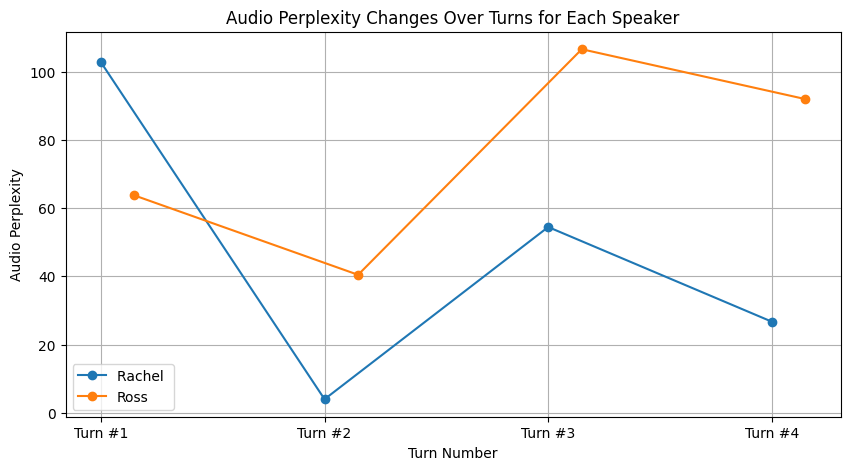

In [24]:
import matplotlib.pyplot as plt

# Separate data by speaker
speakers = list(set(turn['speaker'] for turn in turns))

# Prepare data for plotting
speaker_data = {speaker: [] for speaker in speakers}
for turn in turns:
    speaker_data[turn['speaker']].append(turn['audio_perplexity'])

# Generate x values with offset for second speaker
x_ticks = [f"Turn #{i+1}" for i in range(len(speaker_data[speakers[0]]))]
x_values = {speakers[0]: list(range(len(speaker_data[speakers[0]]))),
            speakers[1]: [x + 0.15 for x in range(len(speaker_data[speakers[1]]))]}

plt.figure(figsize=(10, 5))
for speaker in speakers:
    plt.plot(x_values[speaker], speaker_data[speaker], marker='o', label=speaker)

plt.xticks(range(len(x_ticks)), x_ticks)
plt.xlabel('Turn Number')
plt.ylabel('Audio Perplexity')
plt.title('Audio Perplexity Changes Over Turns for Each Speaker')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
print(speakers[0])
print(np.mean(speaker_data[speakers[0]]))

print(speakers[1])
print(np.mean(speaker_data[speakers[1]]))

Rachel 
46.96963091569674
Ross
75.65562892602554
